In [1]:
%matplotlib inline

In [2]:
import sys
import os
aps_path = os.path.dirname(os.path.abspath("."))
if aps_path not in sys.path:
    sys.path.append(aps_path)
print(aps_path, sys.path)

D:\Dev\APS\aps ['', 'C:\\Anaconda3\\python36.zip', 'C:\\Anaconda3\\DLLs', 'C:\\Anaconda3\\lib', 'C:\\Anaconda3', 'C:\\Anaconda3\\lib\\site-packages', 'C:\\Anaconda3\\lib\\site-packages\\Sphinx-1.5.1-py3.6.egg', 'C:\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\kmu\\.ipython', 'D:\\Dev\\APS\\aps']


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import aps_io.get_arome as ga
from load_region import load_region, clip_region

In [55]:
hour_range = [24, 48]
ncfile = r"\\hdata\grid\metdata\prognosis\meps\det\archive\2019\meps_det_extracted_1km_20190307T00Z.nc"
#jd, altitude, land_area_fraction, nc_vars = ga.nc_load(ncfile, ["altitude_of_0_degree_isotherm"], time_period=[6, 25])
times, altitude, land_area_fraction, nc_vars = ga.nc_load(ncfile, ["altitude_of_0_degree_isotherm", "altitude_of_isoTprimW_equal_0"], time_period=hour_range)

### DIMENSIONS ###
OrderedDict([('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 67
), ('height0', <class 'netCDF4._netCDF4.Dimension'>: name = 'height0', size = 1
), ('isotherm_0C_level', <class 'netCDF4._netCDF4.Dimension'>: name = 'isotherm_0C_level', size = 1
), ('local_vertical_level_192', <class 'netCDF4._netCDF4.Dimension'>: name = 'local_vertical_level_192', size = 1
), ('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1195
), ('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1550
)])
-	time
-	height0
-	isotherm_0C_level
-	local_vertical_level_192
-	x
-	y
### VARIABLES ###
-	time
-	forecast_reference_time
-	height0
-	local_vertical_level_192
-	isotherm_0C_level
-	x
-	y
-	altitude_of_0_degree_isotherm
-	integral_of_surface_net_downward_shortwave_flux_wrt_time
-	altitude_of_isoTprimW_equal_0
-	projection_utm
-	lon
-	lat
Variable 'altitude' is not provided.
Variable 'land_area_fraction' is not provided.


In [56]:
print("From {0} to {1}".format(times[0], times[-1]))
len(times)
#plt.imshow(np.flipud(nc_vars['altitude_of_0_degree_isotherm'][6, :, :]))

From 2019-03-08 00:00:00 to 2019-03-08 23:00:00


24

## Calculating the freezing level

We use the parameters "altitude_of_0_degree_isotherm" and "altitude_of_isoTprimW_equal_0" from [MEPS_extracted](http://thredds.met.no/thredds/catalog/meps25files/catalog.html).
Under dry conditions we use altitude_of_0_degree_isotherm and for timing we use the period with the highest values. With precipitation we use altitude_of_isoTprimW_equal_0 and the period with the highest amount of precipitation.

- split data into four chunks: 0-6, 6-12, 12-18, 18-24
- compress time dimension to 1 by keeping only the maximum value in each cell for each chunk
- calculate the 90-percentile for all max-values within a region
- round 90-percentile for each region to the next 50 m

### Compress time dimension

In [57]:
#fl_max = np.amax(nc_vars['altitude_of_0_degree_isotherm'][0:6,:,:], axis=0)
fl_max = np.amax(nc_vars['altitude_of_isoTprimW_equal_0'][0:6,:,:], axis=0)
fl_max

masked_array(
  data=[[ 796.50903,  795.00903,  795.00903, ..., 1458.3518 , 1458.3518 ,
         1458.3518 ],
        [ 802.75903,  799.13403,  799.13403, ..., 1458.3518 , 1458.3518 ,
         1458.3518 ],
        [ 802.75903,  799.13403,  799.13403, ..., 1458.3518 , 1458.3518 ,
         1458.3518 ],
        ...,
        [-686.74097, -686.74097, -689.24097, ..., -987.49097, -987.49097,
         -988.11597],
        [-686.74097, -686.49097, -689.11597, ..., -987.49097, -987.49097,
         -988.11597],
        [-686.49097, -686.49097, -689.11597, ..., -984.92114, -984.92114,
         -987.99097]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

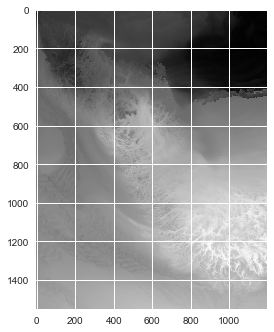

In [58]:
plt.imshow(fl_max)

### Extract regions


In [64]:
# Load region mask - only for data on 1km xgeo-grid
region_mask, y_min, y_max, x_min, x_max = load_region(3034)
print(y_max-y_min, x_max-x_min)

Missing value: -32768
113 107


[ 1. nan nan ... nan nan nan]


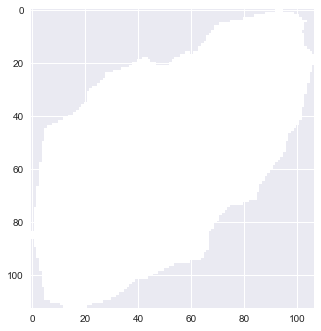

In [65]:
print(np.unique(region_mask))
plt.imshow(region_mask)

In [66]:
t_index = 0
fl_region = clip_region(np.flipud(fl_max), region_mask, t_index, y_min, y_max, x_min, x_max)
#print(np.unique(fl_3034))

4781
[639.8840332 647.5090332 651.0090332 ...         nan         nan
         nan]


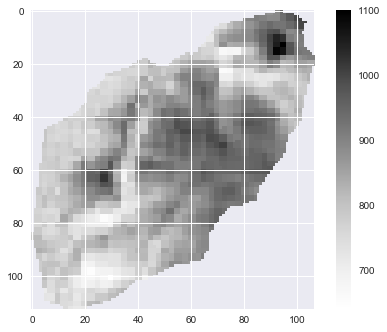

In [67]:
#fl_3034.masked_where(fl_region<=0.0)
print(np.count_nonzero(np.isnan(fl_region)))
print(np.unique(fl_region))
plt.imshow(fl_region)
plt.colorbar()

In [68]:
print("Mean\t: ", np.nanmean(fl_region.flatten()))
for p in [0,5,25,50,75, 80, 85,90, 95,100]:
    print(p, "\t: ", np.nanpercentile(fl_region.flatten(), p))

Mean	:  843.6555026157447
0 	:  639.884033203125
5 	:  723.089111328125
25 	:  780.634033203125
50 	:  840.726806640625
75 	:  908.884033203125
80 	:  921.384033203125
85 	:  935.840283203125
90 	:  946.384033203125
95 	:  962.259033203125
100 	:  1100.384033203125


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


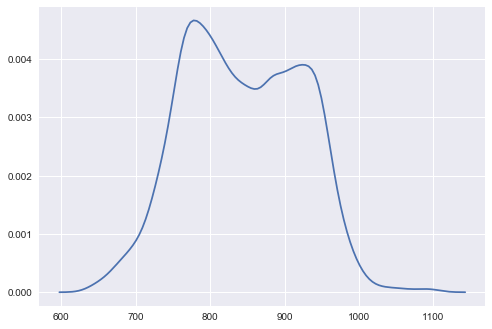

In [69]:
sns.kdeplot(fl_region.flatten())

In [70]:
print(fl_region.flatten())

[nan nan nan ... nan nan nan]
